## Python Script: 1D Put Option

In [1]:
from FB import *
import pandas as pd 
# Important lines for the new Mac
tf.config.list_physical_devices()
tf.config.set_visible_devices([], 'GPU')
# New axes
_n,_t = np.newaxis,tf.newaxis

In [2]:
def mcPrice(NN,J):
    """Compute price with Trained Network NN and J MC simulations."""
    S,Z   = simGBM(s0,r,delta,sig,T,N,d,J,lbda = lbda) # Use a regular grid
    V,*_  = reward(NN,S,a(S),xInfo,phi,K,eta,ts,train = False,Z=Z)
    return V

# Benchmark
fStar  = lambda f0,alpha: lambda t:  tf.cast(K - (K-f0)* (1-t/T)**alpha,"float32")
# Dictionary
fStar_ = {1 : fStar(24.26, .28), 2 : fStar(29.8, .30), 5 : fStar(34., .30) ,
          10: fStar(36.19, .31), 50: fStar(39., .30)} 

def vizBdry(f,lbda = 0.,eps = [0.,0.],saveFig = False,path = "",titles = ""):
    """Plot boundary with trajectories."""
    
    fig, ax = plt.subplots(1,2,figsize=(10, 4))
    S,*_  = simGBM(s0,r,delta,sig,T,N,d,int(2e2),lbda = lbda)
    for k in range(2):
        bdry = pd.DataFrame(f[k],columns=ts.flatten()).T
        bdry.columns    = ["Neural Net"]
        bdry.index.name = "Time"; bdry.reset_index(inplace=True)
        # Plot the boundary
        ax[k].plot(ts,fStar_[1](ts),"-",color="cornflowerblue",lw=2)
        # Add fuzzy corridor
        bdry["eps"],bdry["-eps"] = bdry["Neural Net"] + K * eps[k], bdry["Neural Net"] - K * eps[k]
        bdry.plot("Time",["Neural Net","eps","-eps"],style=["-",':',':'],
          color=["indianred",'darkred','darkred'],ax=ax[k],lw=2,legend="None",zorder=-.5)
        ax[k].fill_between(bdry["Time"],bdry["eps"],bdry["-eps"], color = 'darkred',alpha = 0.4,zorder=-0.75)
        ax[k].plot(ts,a(S).numpy().T,color="steelblue",lw=0.25,zorder=-1,alpha=0.3)
        ax[k].hlines(K,0,T,alpha=0.5,lw=1)
        ax[k].set_xlabel(""); ax[k].set_yticks([0,K]);
        ax[k].set_xlim(0,T); ax[k].set_xticks([0,T]); ax[k].set_xlabel('t')
        ax[k].set_title(titles[k])
        if eta ==-1: ax[k].set_ylim(0., 2*K)
        else:        ax[k].set_ylim(K-5,np.maximum(2*K,np.amax(bdry["Neural Net"])))
        ax[k].get_legend().remove()
    fig.legend(["Optimal","Neural Net",r"$\epsilon$ corridor"],
               loc = "lower center",fontsize=11,ncol=3,bbox_to_anchor=(.5, -0.1))

    if saveFig:
        plt.savefig("Figures/Bdry, lbda=%2.3f, mu=%2.3f, N=%d.pdf"%(lbda,mu,N),dpi=600, bbox_inches='tight')
    plt.show() 
print("Local functions")

Local functions


In [6]:
#==============================================#
#===== Problem parameters and functions =======#
#==============================================#
s0       = 40.    # Spot 
r        =   .06  # Interest rate
delta    =   .0   # Dividend
sig      =   .40  # Volatility
T        =   1.   # Maturity
d        =   1    # Number of assets
N        =   100  # Number of time points (can be larger)
K        =   40.  # Strike
eta      =   -1   # Vanilla type (1: call, -1: put) 
vaniType = "Call" if eta == 1 else "Put" 
optType  = "Max" # Max or Basket 
# Statistics of the asset prices
a        = bskt if optType == "Basket" else max_
# Chosen payoff
phi      = payoff(vanilla(eta,K),a,r)
#===============================================#
#===== Training parameters and functions =======#
#===============================================#
# Batch size and number of iterations
B,M      = 2**9, 5000
# Time grid and increment (regular if beta =1)
ts,dt    = timeGrid(T,N)#,beta = 1/2)
# Initial boundary as percentage of strike (50% if put and 150% if call)
f0       = 1 + eta/2
# Corridor width
eps      = sig * np.sqrt(np.vstack((dt,dt[-1])).flatten())
epsInit  = eps[0]
# DO NOT Shrink the corridor towards the end
epsFinal = epsInit
zeta     = 1. #(epsFinal/epsInit)**(3/M)
# Importance Sampling
mu       = 0.05 # Desired drift (> 0: downward, <0: upward)
lbda     = (r-delta + mu)/sig * np.ones((d,1)) 
# Mean and std of simulations to normalize NN input
S,_      = simGBM(s0,r,delta,sig,T,N,d,int(1e5),dt,lbda)
X        = tf.sort(S/a(S)[:,:,_t],axis=-1,direction = 'DESCENDING')[:,:,1:]
xInfo    = {"mean": tf.reduce_mean(X,axis=0),"std": tfm.reduce_std(X,axis=0)}
# Optimizer
opt      = keras.optimizers.Adam(learning_rate = 1e-3)
# Group all parameters and functions
params   = {"Problem" : (s0,r,delta,sig,T,d,N,K,eta,a,phi), 
            "Training": (B,M,ts,dt,eps,zeta,lbda,xInfo,opt)}

### Run one experiment

Max Put, d = 1, N = 100.
Iteration: 3000/3000
Training: 95 seconds


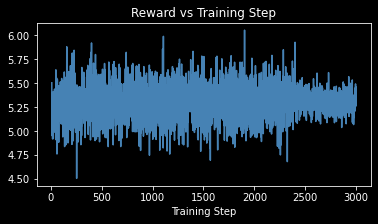

In [7]:
# Training
f = {}
print("%s %s, d = %d, N = %d."%(optType,vaniType,d, N))

NN0 = newNN(f0,d)
f[0] =nnOut(newNN(f0,d),1,N,K,ts).numpy()
NN,runTime = trainFB(NN0,params,show=True)#,rdmS0=True)

f[1]    = nnOut(NN,1,N,K,ts).numpy()

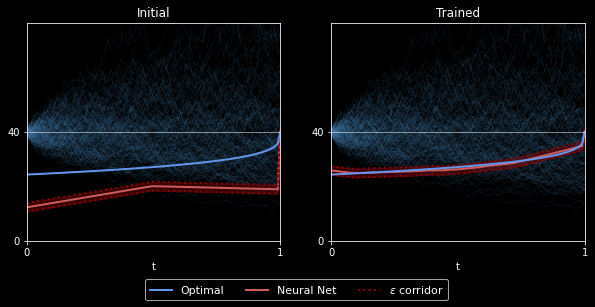

In [8]:
# PLOT
titles = ["Initial", "Trained"]
path   = "Figures"  
f[0] =nnOut(newNN(f0,d),1,N,K,ts).numpy()
vizBdry(f,lbda=lbda, eps = [epsInit,epsFinal],saveFig=True,path = path, titles = titles)

Iteration: 1000/1000
Training: 33 seconds


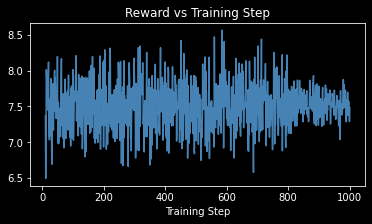

In [9]:
params   = {"Problem" : (s0,r,delta,sig,T,d,N,K,eta,a,phi), 
            "Training": (B,1000,ts,dt,eps,zeta,lbda,xInfo,opt)}
NN1,runTime = trainFB(NN,params,show=True,rdmS0=True)

f_ = {0: f[0], 1: nnOut(NN,1,N,K,ts).numpy()}


In [10]:
vizBdry(f_,lbda=lbda, eps = epsMax,saveFig=False,path = path, titles = titles)

NameError: name 'epsMax' is not defined

In [68]:
J=int(2**18)
mcPrice(NN,J)

5.314594

Iteration: 500/500
Training: 22 seconds


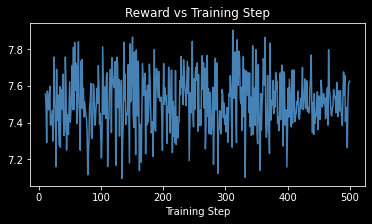

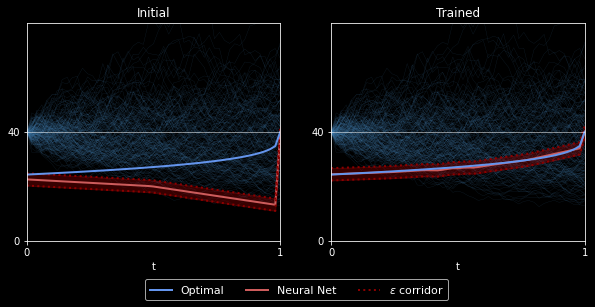

In [81]:
lbda = (r-delta)/sig * np.ones((d,1)) + 0.15

params   = {"Problem" : (s0,r,delta,sig,T,d,N,K,eta,a,phi), 
            "Training": (2**11,500,ts,dt,eps,zeta,lbda,xInfo,opt)}

NN,runTime = trainFB(NN,params,show=True,rdmS0=True)

f[1]    = nnOut(NN,1,N,K,ts).numpy()
vizBdry(f,lbda=lbda, eps = [epsInit,epsFinal],saveFig=True,path = path, titles = titles)

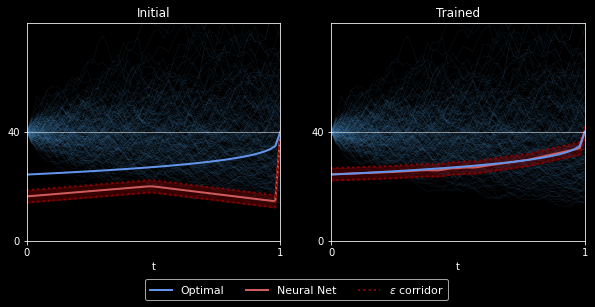

In [82]:
f[0] =nnOut(newNN(f0,d),1,N,K,ts).numpy()
vizBdry(f,lbda=lbda, eps = [epsInit,epsFinal],saveFig=True,path = path, titles = titles)

In [104]:
#S,Z   = simGBM(s0,r,delta,sig,T,N,d,J,lbda = lbda) # Use a regular grid
#V,*_  = reward(NN,S,a(S),xInfo,phi,K,eta,ts,train = False,Z=Z)

def mc(f,J):
    S,Z   = simGBM(s0,r,delta,sig,T,N,d,J) # Use a regular grid
    # Signed distance to the boundary
    dist = eta * (f - a(S))/K   
    u = tf.where(dist <= 0.,1.,0.) # Sharp  Interface
    # Stopping probabilities
    v = tf.concat([tf.ones_like(u[:,0:1]),1 - u[:,:-1] + 1e-10],axis=1)
    w = tf.concat([u[:,:-1], tf.ones_like(u[:,0:1])],axis=1) 
    U = w * tfm.cumprod(v,axis = 1) 
    # Stopping times and stopped values
    tau = tf.reduce_sum(np.arange(0,N+1) * U,axis=1)
    s,z = tf.reduce_sum(U[:,:,_t]*S,axis=1),tf.reduce_sum(U[:,:,_t]*Z,axis=1)
    # Change scale
    tauDt = np.array([ts[int(t)] for t in tau]).T
    # No training -> simply use the values at stopping time
    if len(tau) > 0: G = tf.reshape(z,[-1]) * phi(tauDt,s)
    else           : G = 0. 
    V,V2 =  np.mean(G),  np.mean(G**2)
    return V,np.sqrt((V2 - V**2)/J)

In [112]:
fOpt = tf.transpose(fStar_[1](ts))

V0,std0 = np.zeros(I),np.zeros(I)
for i in range(5): 
    V0[i],std0[i] = mc(fOpt,int(2**19))
    print("Price: %2.4f. Std: %2.4f"%(V0[i],std0[i]))
    
print("Average: %2.4f. Std: %2.4f"%(np.mean(V0),np.std(V0)))

Price: 5.3220. Std: 0.0080
Price: 5.3147. Std: 0.0080
Price: 5.3101. Std: 0.0080
Price: 5.3083. Std: 0.0080
Price: 5.3049. Std: 0.0080
Average: 2.6560. Std: 2.6560


In [110]:
np.mean([5.3094,5.3151, 5.3063, 5.3095,5.3122])

5.3105

In [102]:
tf.transpose(fStar_[1](ts))

<tf.Tensor: shape=(1, 51), dtype=float32, numpy=
array([[24.26    , 24.348785, 24.438887, 24.530348, 24.623222, 24.717562,
        24.813423, 24.910866, 25.009954, 25.110758, 25.213346, 25.317797,
        25.424196, 25.532629, 25.643194, 25.755993, 25.871138, 25.988745,
        26.108948, 26.231888, 26.357716, 26.486603, 26.618729, 26.754297,
        26.893532, 27.036678, 27.184006, 27.335825, 27.492472, 27.654333,
        27.821844, 27.995499, 28.175863, 28.363596, 28.559454, 28.764338,
        28.979305, 29.205631, 29.444862, 29.698912, 29.97018 , 30.261747,
        30.57767 , 30.923454, 31.306885, 31.73953 , 32.239853, 32.840427,
        33.608814, 34.736275, 40.      ]], dtype=float32)>